# Example segmentation with DeepLabv3+

In [ ]:
import numpy as np
from glob import glob
import tensorflow as tf


In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from tensorflow.keras.backend import max

This example requires `swiss_army_keras` or higher:
```
pip3 install swiss_army_keras
```

In [3]:
from swiss_army_keras import models, base, utils, quantization_utils, training_utils, dataset_utils

In [4]:
# the indicator of a fresh run
first_time_running = False

# user-specified working directory
filepath = '/home/matteo/Documents/oxford_iiit/'

## The Oxford-IIIT Pets dataset

This example applies the dataset of [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (Parkhi et al. 2012). This dataset contains images of pets and their pixel-wise mask that indicates (1) pixels belonging to the pet, (2) pixels bordering the pet, and (3) surrounding pixels.

The Oxford-IIIT Pets dataset will be downloaded and unpacked through the cell blow.

In [5]:
if first_time_running:
    # downloading and executing data files
    import tarfile
    import urllib.request
    
    filename_image = filepath+'images.tar.gz'
    filename_target = filepath+'annotations.tar.gz'
    
    urllib.request.urlretrieve('http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz', filename_image);
    urllib.request.urlretrieve('https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz', filename_target);
    
    with tarfile.open(filename_image, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)
    with tarfile.open(filename_target, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)
    os.system(f'cd {filepath} && cd images && rm *.mat && cd../../')    

In [6]:
import albumentations as albu


In [7]:
from swiss_army_keras.dataset_utils import SegmentationAlbumentationsDataLoader
from weathermentations.rain import DropsOnLens

In [8]:
n_labels = 3

input_tensor = tf.keras.layers.Input((64, 64, 3), batch_size=1)

X_decoder = models.deeplab_v3_plus(input_tensor,
                                   n_labels=n_labels,
                                   backbone='EfficientNetLiteB0',
                                   atrous_rates=[],
                                   deep_layer=5,
                                   activation='ReLU',
                                   batch_norm=True,
                                   pool=True,
                                   unpool=True,
                                   name='Pets')



OUT_stack = X_decoder(input_tensor)
deeplabv3pluslite = keras.models.Model([input_tensor,], OUT_stack)
deeplabv3pluslite.preprocessing = X_decoder.preprocessing
deeplabv3pluslite.summary()

KerasTensor(type_spec=TensorSpec(shape=(1, 64, 64, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 64, 64, 3)]          0         
_________________________________________________________________
model (Functional)           (1, 64, 64, 3)            4652771   
Total params: 4,652,771
Trainable params: 2,021,731
Non-trainable params: 2,631,040
_________________________________________________________________


In [9]:
def get_training_augmentation(width=513, height=513):
    train_transform = [
        

        #albu.RandomRotate90(p=0.5),
        
        #albu.OneOf([
        #   
        #   
        #], p=1),
        #albu.Resize(width, height, 2, p=1),

        #albu.ShiftScaleRotate(shift_limit = 0.05, scale_limit=(0.1, 0.1), interpolation=2, rotate_limit=25, p=0.3),
        
        albu.HorizontalFlip(p=0.5),
        #albu.VerticalFlip(p=0.15),

        albu.Compose([
        albu.OneOf([
            albu.ISONoise(p=1),
            albu.MultiplicativeNoise(p=1),
            albu.GaussNoise(p=1),
            albu.ImageCompression(p=1),

            ], 
            p=1,
        ),
        
        #albu.Perspective(pad_mode=2, p=0.1),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.Sharpen(p=1),
                albu.Emboss(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.5,
        ),

        albu.OneOf(
            [
                albu.Blur(blur_limit=5, p=1),
                albu.MedianBlur(blur_limit=5, p=1),
                albu.MotionBlur(blur_limit=5, p=1),
            ],
            p=0.25,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
                albu.RGBShift(p=1),
            ],
            p=0.25,
        ),
        
        albu.OneOf(
            [
                #albu.ElasticTransform(alpha=10, sigma=10 * 0.05, alpha_affine=10 * 0.03, p=0.5),
                albu.GridDistortion(p=0.5),
                albu.OpticalDistortion(distort_limit=0.3, shift_limit=0.05, p=1)      
            ],
            p=0.25,
        )], p=0.5),
        
        #DropsOnLens(maxR=40, minR=30, p=0.1),
        albu.ToGray(p=0.2)
    ]
    
    return albu.Compose(train_transform)
    #return albu.Compose([])


loader = SegmentationAlbumentationsDataLoader(num_classes=3,
                                              #precache=True,
                                              batch_size=16,
                                              width=64,
                                              height=64,
                                              dataset_path=filepath,
                                              masks_dir='annotations/trimaps',
                                              train_augmentations=get_training_augmentation(64, 64),
                                              label_shift=1,
                                              train_val_test_split=[0.8, 0.1, 0.1],
                                              normalization=deeplabv3pluslite.preprocessing,
                                              )


Train Images are good to go


In [10]:
train_set, val_set, test_set = loader.build_datasets()

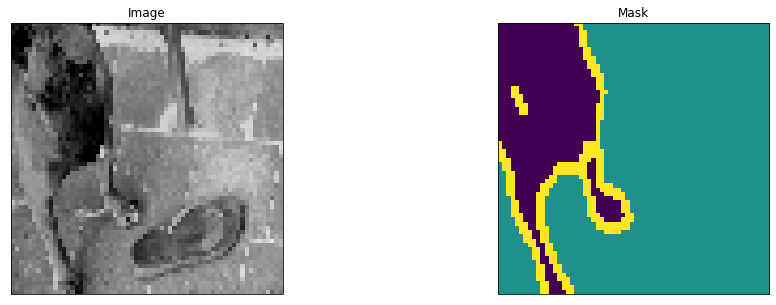

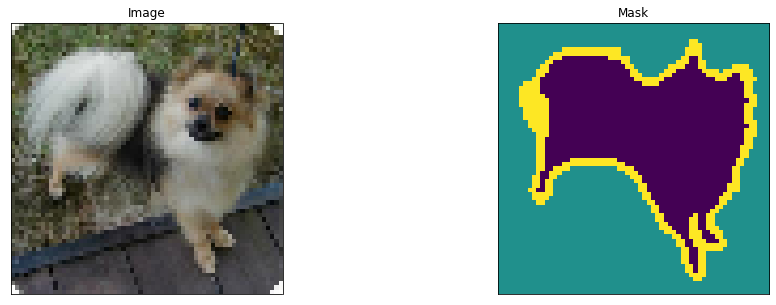

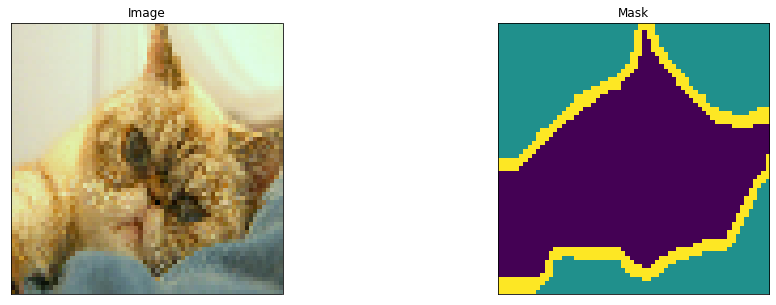

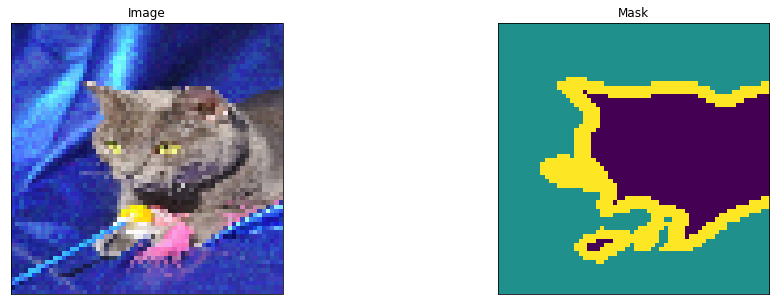

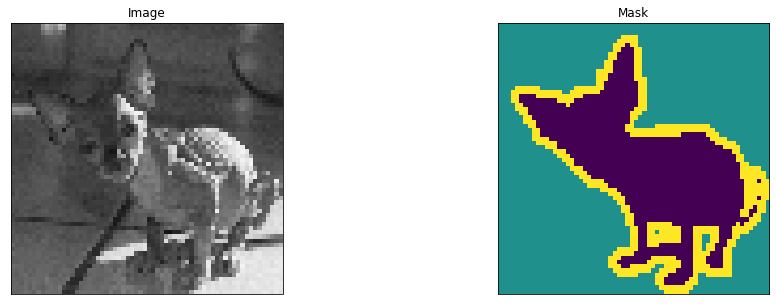

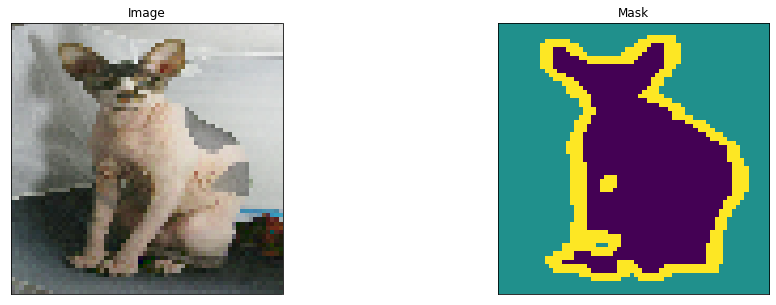

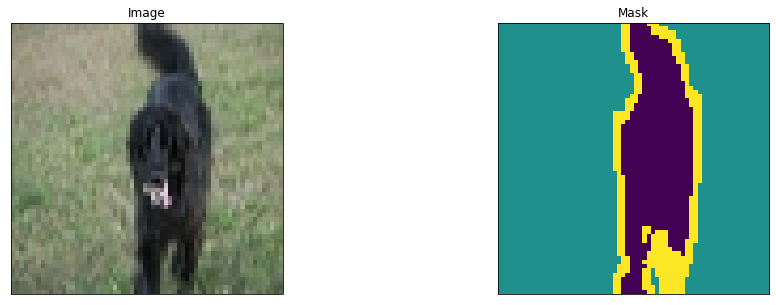

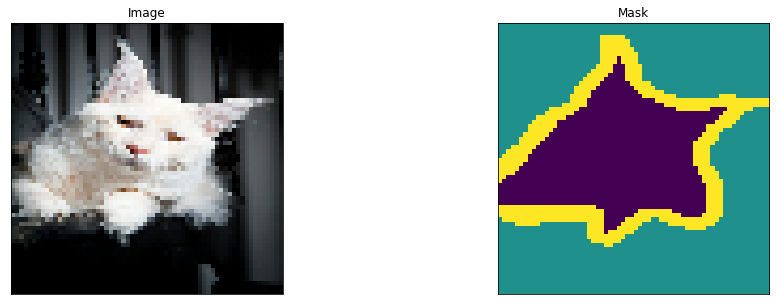

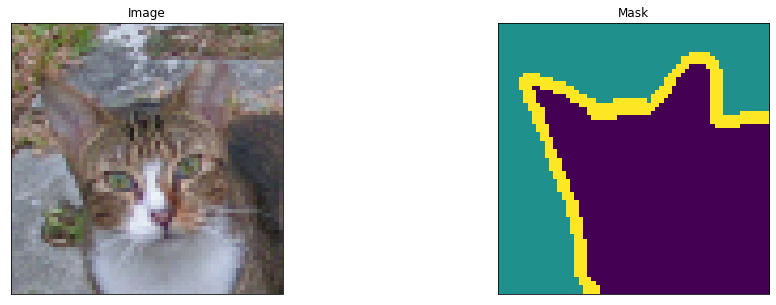

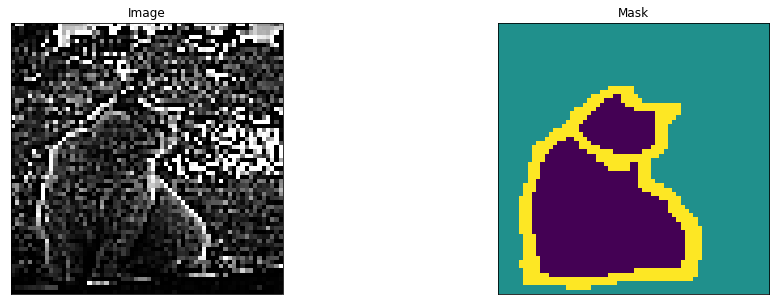

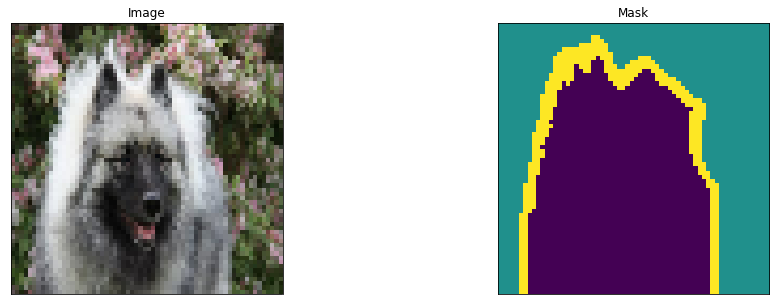

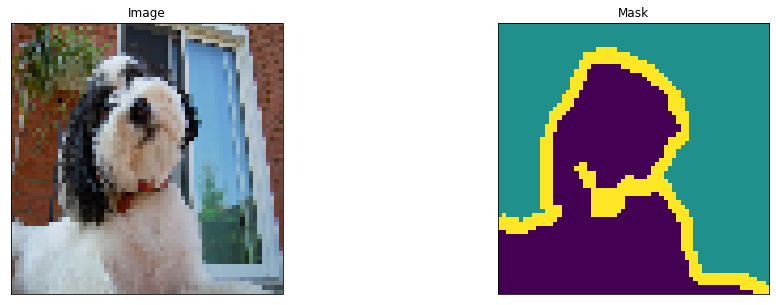

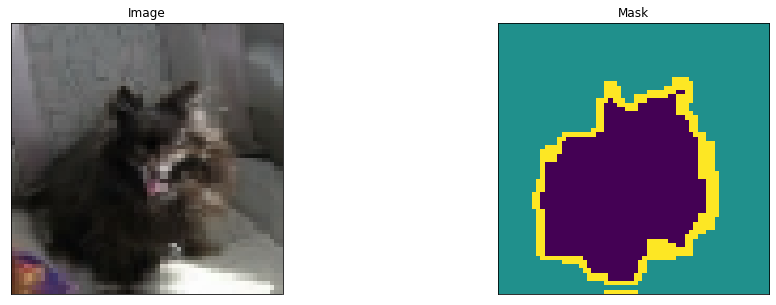

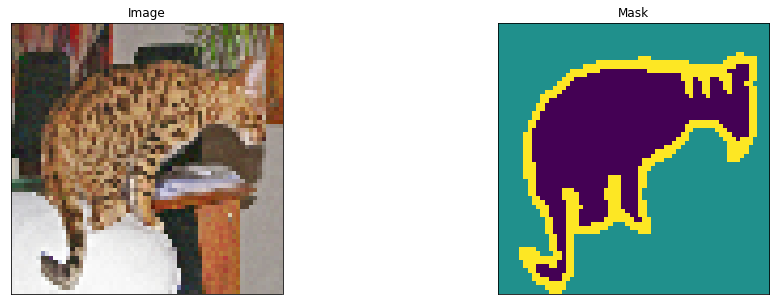

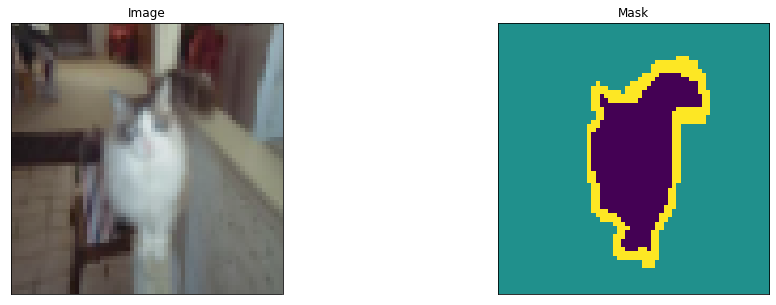

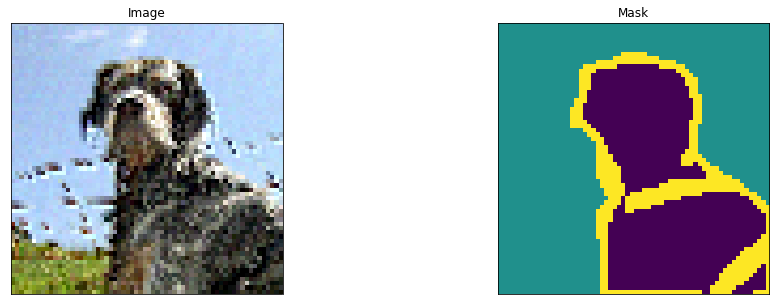

In [11]:
loader.show_images(dset='train', num_images=16)

In [12]:
loader.datasets

{'train': <ParallelMapDataset shapes: ((16, 64, 64, 3), (16, 64, 64, 3)), types: (tf.float32, tf.float32)>,
 'val': <ParallelMapDataset shapes: ((16, 64, 64, 3), (16, 64, 64, 3)), types: (tf.float32, tf.float32)>,
 'test': <ParallelMapDataset shapes: ((16, 64, 64, 3), (16, 64, 64, 3)), types: (tf.float32, tf.float32)>}

In [13]:
from swiss_army_keras.training_utils import TrainingDriver

In [14]:
td = TrainingDriver(deeplabv3pluslite,'pets_model', tf.keras.optimizers.Adam(), tf.keras.losses.CategoricalCrossentropy(from_logits=True), [tf.keras.metrics.CategoricalAccuracy()], train_set, val_set, test_set, 1 )

In [15]:
td.run()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 64, 64, 3)]          0         
_________________________________________________________________
model (Functional)           (1, 64, 64, 3)            4652771   
Total params: 4,652,771
Trainable params: 2,021,731
Non-trainable params: 2,631,040
_________________________________________________________________


/home/matteo/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


 19/369 [>.............................] - ETA: 2:54 - loss: 1.0064 - categorical_accuracy: 0.6210

KeyboardInterrupt: 

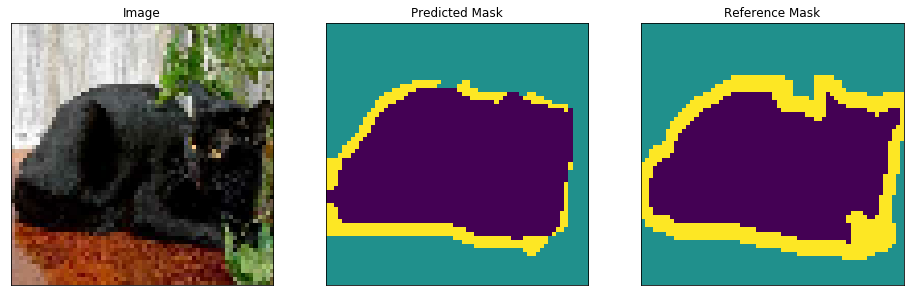

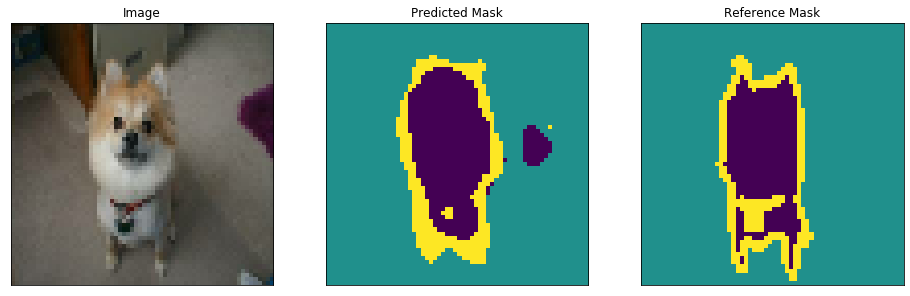

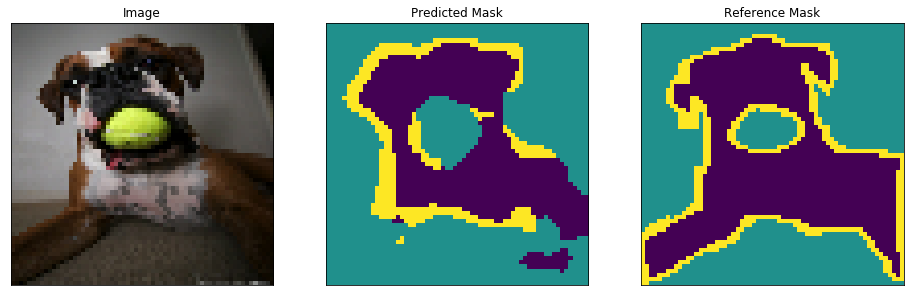

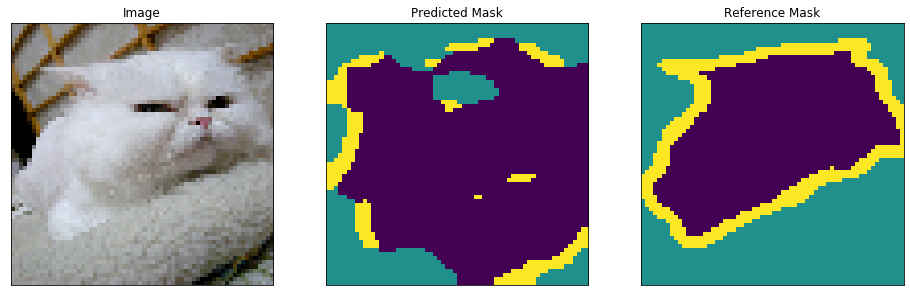

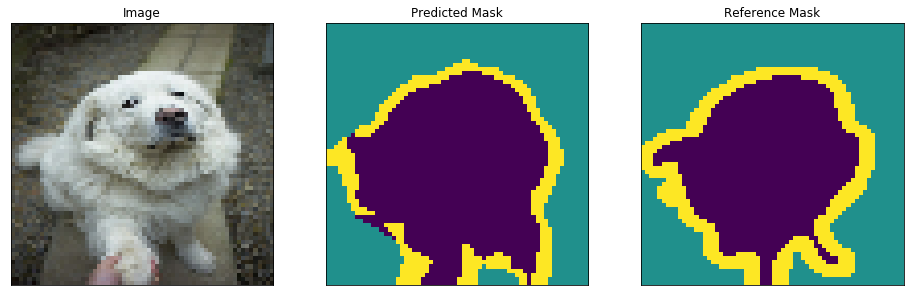

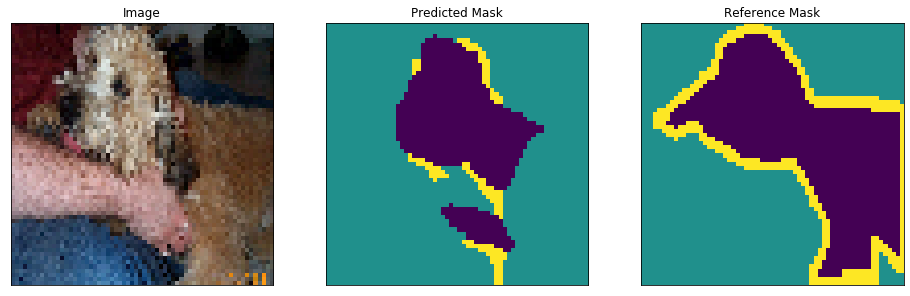

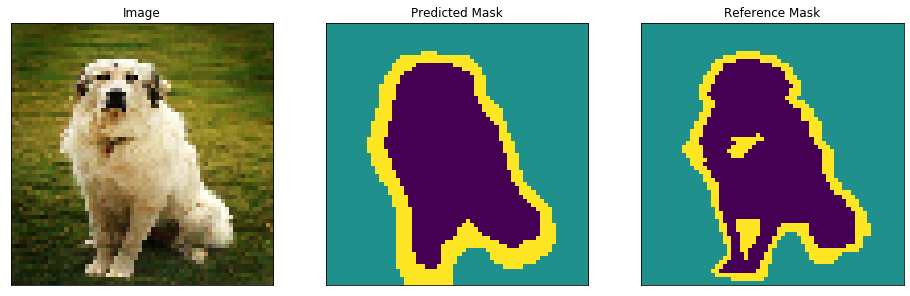

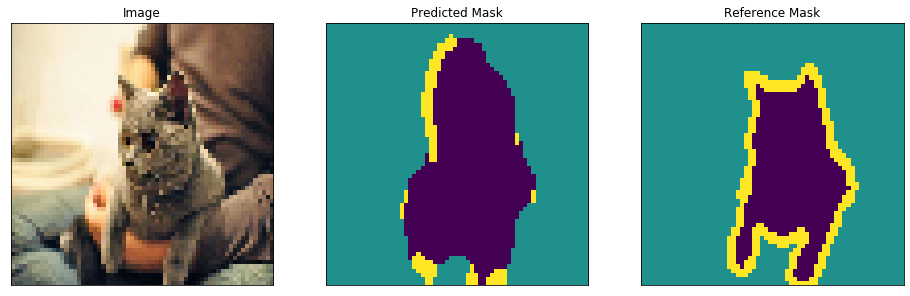

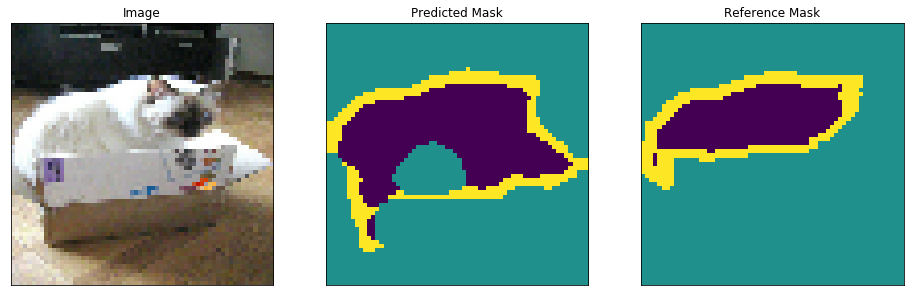

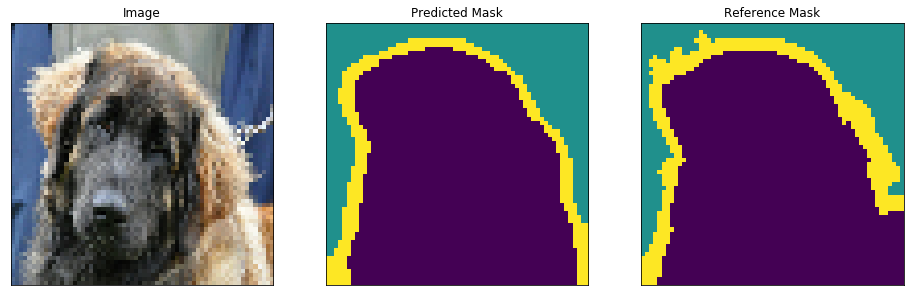

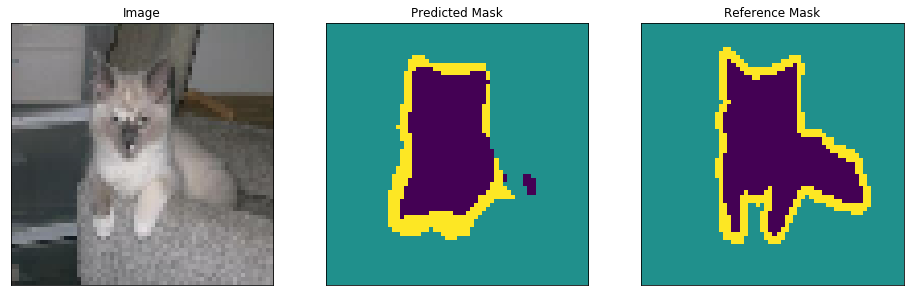

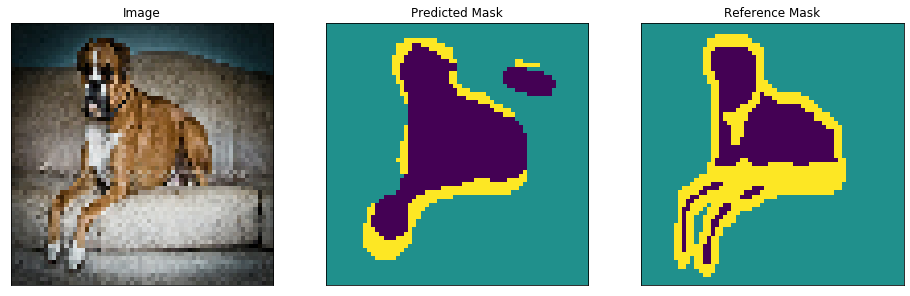

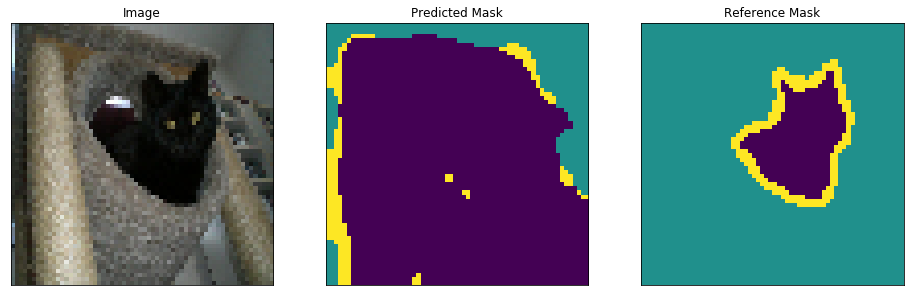

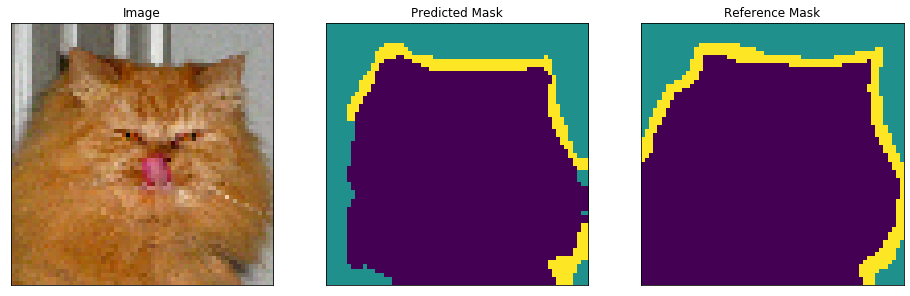

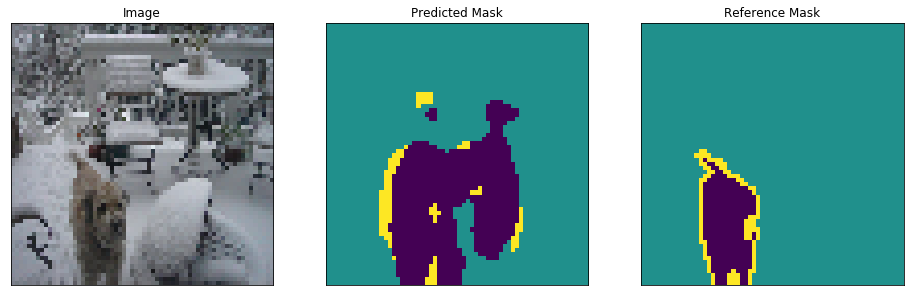

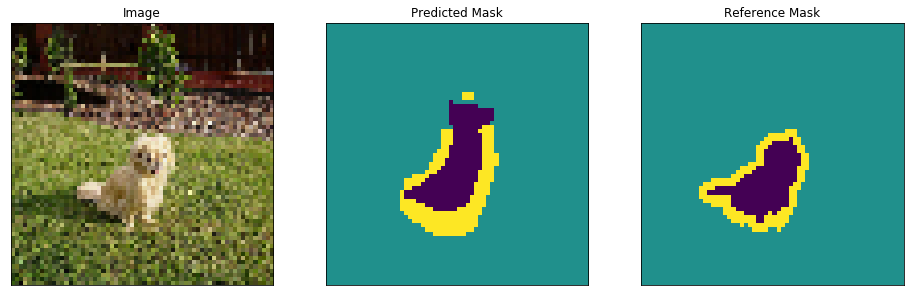

In [16]:
loader.show_results(deeplabv3pluslite, 16)